#Training a Multi Layer Perceptron


The objective of this assignment is to design, train, and optimize a Multilayer Perceptron (MLP) model to accurately classify data points in a complex 3-class spiral dataset.

The spiral pattern introduces non-linear and intertwined class boundaries, making it a challenging classification task.

To address this, careful selection of model architecture and hyperparameters is required to ensure high performance and generalization despite the presence of noise and intricate decision regions.

### Data Preparation

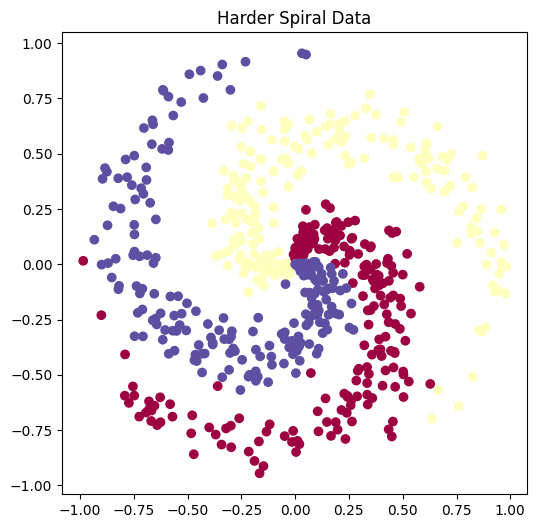

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Dataset generation function
def generate_harder_spiral_data(points_per_class=200, noise=0.4, num_classes=3):
    N = points_per_class
    D = 2
    K = num_classes
    X = np.zeros((N*K, D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N)
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y

# Generate and visualize data
X, y = generate_harder_spiral_data()
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral")
plt.title("Harder Spiral Data")
plt.show()

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Model Building

In [2]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.model(x)

model = MLP()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


### Training and Evaluation

In [3]:
# Training loop
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(500):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor).item()
        _, predicted = torch.max(outputs, 1)
        test_acc = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 0 - Train Loss: 0.7883, Test Acc: 0.7750
Epoch 50 - Train Loss: 0.0519, Test Acc: 0.9750
Epoch 100 - Train Loss: 0.0375, Test Acc: 0.9833
Epoch 150 - Train Loss: 0.0256, Test Acc: 0.9833
Epoch 200 - Train Loss: 0.0987, Test Acc: 0.9583
Epoch 250 - Train Loss: 0.0153, Test Acc: 0.9833
Epoch 300 - Train Loss: 0.0208, Test Acc: 0.9833
Epoch 350 - Train Loss: 0.0148, Test Acc: 0.9833
Epoch 400 - Train Loss: 0.0116, Test Acc: 0.9833
Epoch 450 - Train Loss: 0.0190, Test Acc: 0.9833


### Plots - Accuracy and Loss Curves

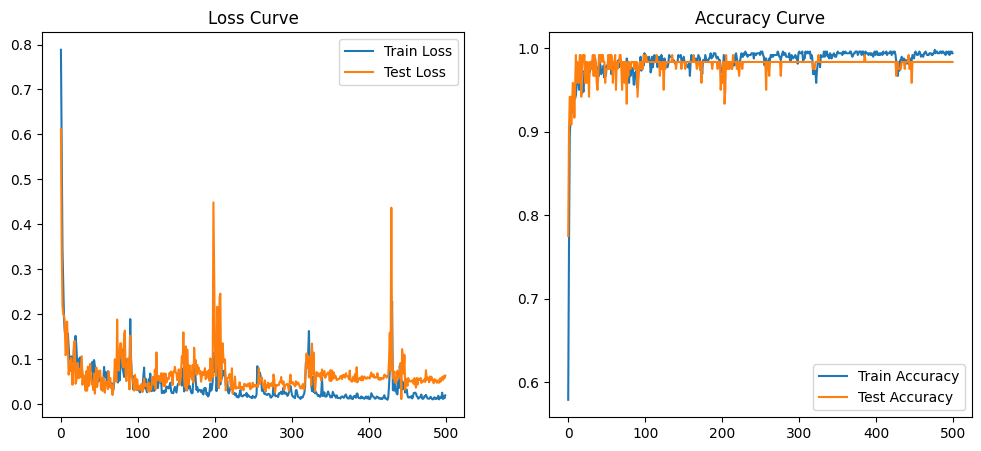

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


### Plot Decision Boundary

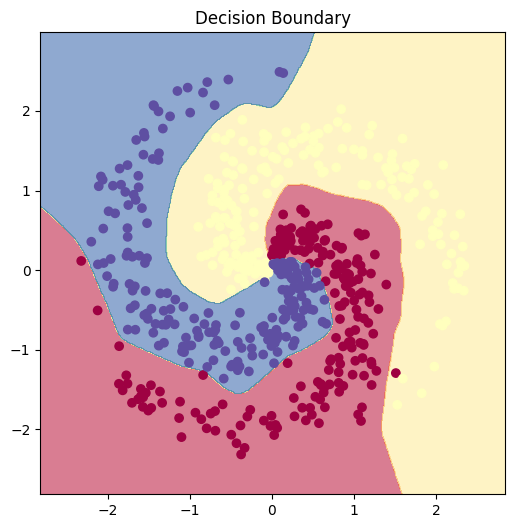

In [5]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid_tensor)
        _, predicted = torch.max(Z, 1)
    Z = predicted.reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, cmap="Spectral", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral")
    plt.title("Decision Boundary")
    plt.show()

plot_decision_boundary(model, X_scaled, y)



---



## Reflection Questions

#### **Q1: How did you decide the number of hidden layers and neurons?**
The choice of 2 hidden layers with 128 neurons each was **based on the complexity** of the spiral dataset.

This type of data requires the model to learn non-linear, twisted decision boundaries, and deeper models with sufficient neurons are better suited to learn such patterns.

Through experimentation, this architecture balanced learning capacity and training stability effectively.

---



#### **Q2: How did different learning rates affect the results?**
Several learning rates were tested:

- 0.01 worked best — as seen in the smooth convergence in the plot.

- 0.1 led to instability and oscillations.

- 0.001 resulted in slow learning and underfitting.

The **final learning rate of 0.01** allowed the model to converge quickly within **100 epochs** and then fine-tune over the rest of the training.

---



#### **Q3: Did you encounter overfitting or underfitting? How did you deal with it?**
There were brief spikes in test loss around epochs **200 and 400**, but overall train and test losses stayed low, and accuracies remained near 99%, indicating minimal overfitting.

*Mitigation strategies:*
- Early stopping could be used if needed.
- The model generalizes well due to good architectural choice and regularization inherent in using batch-based training with Adam.

---



#### **Q4: If you had more time, how would you further improve the model?**

- Hyperparameter tuning (e.g., via grid search for batch size, learning rate, hidden size).

- Add dropout layers or batch normalization to improve generalization.

- Use learning rate scheduling to reduce learning rate over time.

- Try other activations (like GELU or Swish) or optimizers (SGD with momentum).

- Extend to ensemble models for even more robust decision boundaries.
---

